# DAgger.
See the code provided in run expert.py to see how to query the expert policy
and perform roll-outs in the environment.
1. Implement DAgger. See the code provided in run expert.py to see how to query the expert policy
and perform roll-outs in the environment.

2. Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral
cloning. Report your results in the form of a learning curve, plotting the number of DAgger iterations
vs. the policy’s mean return, with error bars to show the standard deviation. Include the performance
of the expert policy and the behavioral cloning agent on the same plot. In the caption, state which
task you used, and any deta

In [166]:
import gym
import load_policy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import tf_util
import tqdm

from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam

%matplotlib inline


In [167]:
env_name = "Reacher-v1"

In [168]:
# Parameters setting
def get_training_opts():
    return dict(validation_split=0.1,
                batch_size=256,
                nb_epoch=50,
                verbose=2)


In [169]:
def regularized_model(num_inputs, num_outputs):
    from keras.regularizers import l2, activity_l2
    model = Sequential()
    model.add(Dense(64, input_dim=num_inputs, init='normal', activation='relu',W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01),b_regularizer=l2(0.01)))
    model.add(Dense(64, input_dim=num_inputs, init='normal', activation='relu',W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01),b_regularizer=l2(0.01)))
    model.add(Dense(num_outputs, init='normal',W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01),b_regularizer=l2(0.01)))
    
    model.compile(loss='mse', optimizer='adam')
    return model
    
def wide_model(num_inputs, num_outputs):
    model = Sequential()
    model.add(Dense(128, input_dim=num_inputs, init='normal', activation='relu'))
    model.add(Dense(num_outputs, init='normal'))

    model.compile(loss='mse', optimizer='adam')
    return model

def get_trainned_model(env):
    observations_dim = env.observation_space.shape[0]
    actions_dim = env.action_space.shape[0]
    model=wide_model(observations_dim, actions_dim)
    
    print('get_trainned_model completed')
    return model


def get_data_of_expert_policy(policy_fn ,env, num_rollouts, render):
    print("begin get data")
    with tf.Session():
        tf.variables_initializer
        max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
        print ("Total rollouts for building policy: ", num_rollouts)
        returns = []
        observations = []
        actions = []
        steps_numbers = []
    
    
        for i in (range(num_rollouts)):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if render:
                    env.render()
                if steps >= max_steps:
                    break
            steps_numbers.append(steps)
            returns.append(totalr)

        expert_data = {'observations': np.array(observations),
                   'actions': np.array(actions),
                   'returns': np.array(returns),
                   'steps': np.array(steps_numbers)}


    return expert_data



def load_policy_fn(env_name):
    print('Gathering expert data')
    print('loading and building expert policy')
    policy_fname = 'experts/{}.pkl'.format(env_name)
    policy_fn = load_policy.load_policy(policy_fname)
    print('loaded and built')
    return policy_fn


def run_trained_model(model, env, rollouts=100, render=False):
    max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    returns = []
    observations = []
    actions = []
    steps_numbers = []

    for i in range(rollouts):
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = model.predict(obs[None, :])
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if render:
                env.render()
            if steps >= max_steps:
                break
        steps_numbers.append(steps)
        returns.append(totalr)  
        
    return {'observations': np.array(observations),
            'actions': np.array(actions),
            'returns': np.array(returns),
            'steps': np.array(steps_numbers)}



def run_expert_on_observations(observations, policy_fn):
    with tf.Session():
        tf.variables_initializer
        actions=[]
        
        for obs in observations:
            action = policy_fn(obs[None,:])
            actions.append(action)
    return np.array(actions)

def get_performance_stat(data):
    mean=data['returns'].mean()
    std=data['returns'].std()
    x=data['steps']
    
    return pd.Series({
        'mean reward': mean,
        'std reward': std
    })

# Dagger
Algorithm in Dagger:
- 1) train cloned policy pi(u_t, o_t) from expert data
- 2) run pi(u_t, o_t) to get data set D_pi={o_1,...o_M}
- 3) Ask human to label D_pi with action
- 4) Aggregate the dataset


In [170]:
env_name = "Humanoid-v1"
num_rollouts=6
render=False

In [171]:
policy_fn=load_policy_fn(env_name)

#  0) Get the params for the training model
training_params=get_training_opts()
#  Get the training data for the training model
env=gym.make(env_name)
data=get_data_of_expert_policy(policy_fn, env, num_rollouts, render)

x=data['observations']
actions_dim = env.action_space.shape[0]

y=data['actions'].reshape(-1, actions_dim)
stats={}
rewards={}

for i in range(5):
    # 1) Train the model
    model=get_trainned_model(env)

    x, y=shuffle(x, y)

    model.fit(x,y,**training_params)

    # 2) Get the generated data
    data_generated=run_trained_model(model, env, render=False)
    stats[i]=get_performance_stat(data_generated)
    rewards[i]=data_generated['returns']
    x_new=data_generated['observations']

    # 3) Get the label with generated data
    y_new=run_expert_on_observations(x_new, policy_fn)

    # 4) Aggregate the data 
    x=np.append(x, x_new, axis=0)
    y=np.append(y,y_new.reshape(-1, actions_dim), axis=0)
# Test the model performance with aggregated dataset



[2017-02-18 19:56:53,101] Making new env: Humanoid-v1


Gathering expert data
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
begin get data
Total rollouts for building policy:  6
get_trainned_model completed
Train on 5400 samples, validate on 600 samples
Epoch 1/50
0s - loss: 78.8131 - val_loss: 15.3881
Epoch 2/50
0s - loss: 7.8037 - val_loss: 3.6206
Epoch 3/50
0s - loss: 2.8294 - val_loss: 1.9462
Epoch 4/50
0s - loss: 1.7683 - val_loss: 1.3788
Epoch 5/50
0s - loss: 1.3304 - val_loss: 1.1202
Epoch 6/50
0s - loss: 1.1159 - val_loss: 0.9666
Epoch 7/50
0s - loss: 0.9442 - val_loss: 0.8587
Epoch 8/50
0s - loss: 0.8237 - val_loss: 0.7585
Epoch 9/50
0s - loss: 0.7307 - val_loss: 0.6957
Epoch 10/50
0s - loss: 0.6644 - val_loss: 0.6353
Epoch 11/50
0s - loss: 0.5993 - val_loss: 0.5870
Epoch 12/50
0s - loss: 0.5549 - val_loss: 0.5747
Epoch 13/50
0s - loss: 0.5385 - val_loss: 0.5210
Epoch 14/50
0s - loss: 0.4773 - val_loss: 0.4674
Epoch 15/50
0s - loss: 0.4382 - val_loss: 0.4374
Epoch 16/50
0s - loss: 0.4105 - val_loss: 0.41

In [172]:
# Save the performance of  training  model without using the DAgger data 
df=pd.DataFrame(stats).T
pickle_name='data/{}-DAgger-rewards.p'.format(env_name)
df.index.name='iterations'
df.to_csv('data/{}-DAgger.csv'.format(env_name))
pickle.dump(rewards, open(pickle_name,'wb'))

# Show the Results


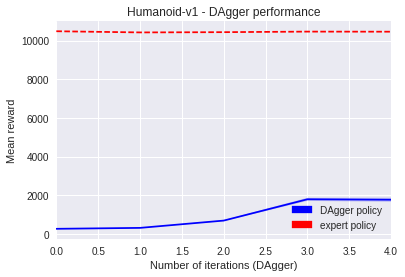

In [174]:
pickle_name='data/{}-DAgger-rewards.p'.format(env_name)
rewards=pickle.load(open(pickle_name,'rb'))

pickle_name='data/{}-their.p'.format(env_name)
their_data=pickle.load(open(pickle_name,'rb'))['returns']

df=pd.DataFrame(rewards)

sns.tsplot(data=their_data, color='red', linestyle='--')
sns.tsplot(time=df.columns, data=df.values, color='blue', linestyle='-')
plt.ylabel("Mean reward")
plt.xlabel("Number of iterations (DAgger)")
plt.title("{} - DAgger performance".format(env_name))

import matplotlib.patches as mpatches
plt.legend(handles=[
    mpatches.Patch(color='blue', label='DAgger policy'),
    mpatches.Patch(color='red', label='expert policy'),
], loc='lower right')

plt.savefig("dagger-{}.png".format(env_name),format='png')